# Data visualizations:

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession\
    .builder\
    .appName("BigData_TG_FE")\
    .config("spark.sql.shuffle.partitions",6)\
    .config("spark.sql.repl.eagereval.enabled",True)\
    .getOrCreate()

23/05/28 10:37:38 WARN Utils: Your hostname, LAPTOP-9G9U9JFG resolves to a loopback address: 127.0.1.1; using 172.18.83.192 instead (on interface eth0)
23/05/28 10:37:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/28 10:37:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
%%bash
pwd

/home/jdsds1


In [3]:
# Some general imports 

import os
import sys

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")

### Data Analysis:

In [4]:
bikes_and_stations = spark.read.parquet("dataout-aws/londonbikes")

In [5]:
def plotBar(df, xcol, ycol, huecol=None):
    return sns.barplot(data=df, x=xcol, y=ycol, hue=huecol)

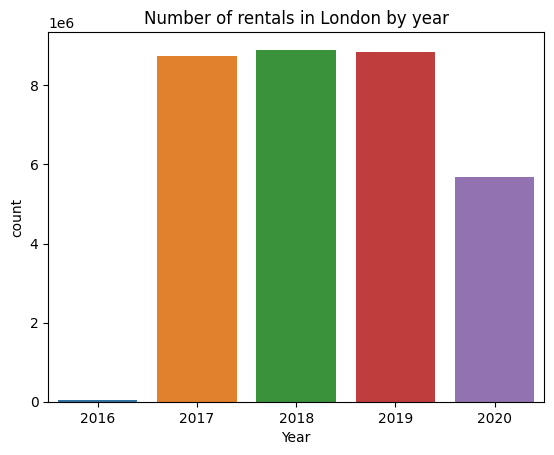

In [6]:
df_plot = ( bikes_and_stations
                .groupby('Year')
                .count()
                .sort('Year', ascending=True)
                .toPandas()
          )
plotBar(df_plot, 'Year', 'count')
plt.title('Number of rentals in London by year')
plt.show()

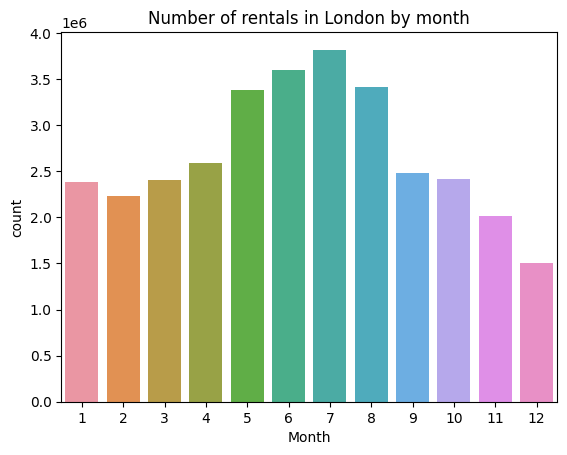

In [7]:
df_plot = ( bikes_and_stations
                .groupby('Month')
                .count()
                .sort('Month', ascending=True)
                .toPandas()
          )
plotBar(df_plot, 'Month', 'count')
plt.title('Number of rentals in London by month')
plt.show()

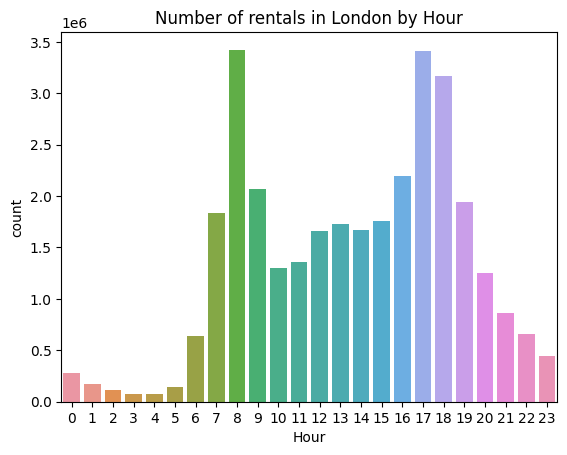

In [8]:
df_plot = ( bikes_and_stations
                .groupby('Hour')
                .count()
                .sort('Hour', ascending=True)
                .toPandas()
          )
plotBar(df_plot, 'Hour', 'count')
plt.title('Number of rentals in London by Hour')
plt.show()

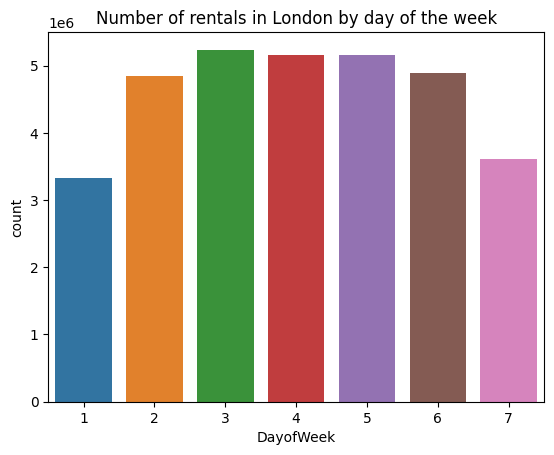

In [9]:
df_plot = ( bikes_and_stations
                .groupby('DayofWeek')
                .count()
                .sort('DayofWeek', ascending=True)
                .toPandas()
          )
plotBar(df_plot, 'DayofWeek', 'count')
plt.title('Number of rentals in London by day of the week')
plt.show()

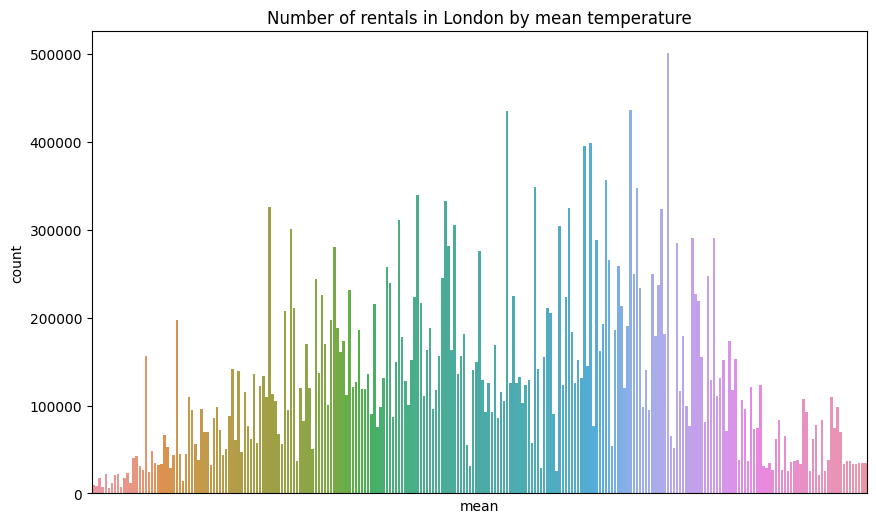

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

df_plot = ( bikes_and_stations
                .groupby('mean')
                .count()
                .sort('mean', ascending=True)
                .toPandas()
          )
bar_plot = plotBar(df_plot, 'mean', 'count')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.title('Number of rentals in London by mean temperature')
plt.show()

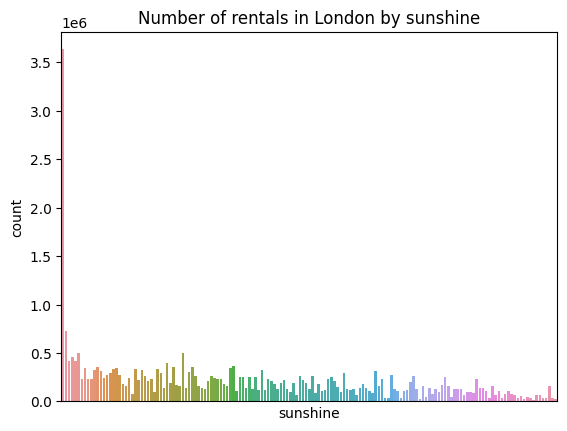

In [11]:
df_plot = ( bikes_and_stations
                .groupby('sunshine')
                .count()
                .sort('sunshine', ascending=True)
                .toPandas()
          )
plotBar(df_plot, 'sunshine', 'count')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.title('Number of rentals in London by sunshine')
plt.show()

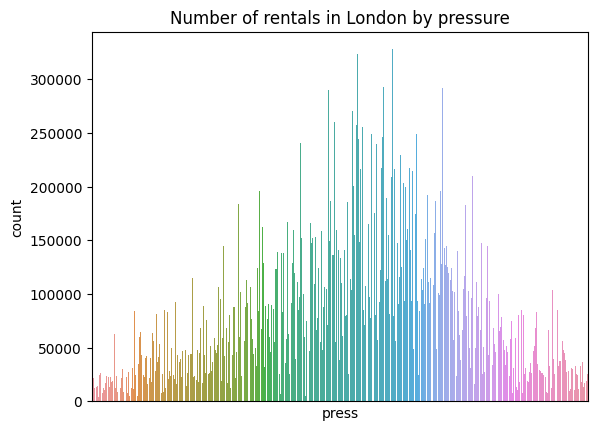

In [12]:
df_plot = ( bikes_and_stations
                .groupby('press')
                .count()
                .sort('press', ascending=True)
                .toPandas()
          )
plotBar(df_plot, 'press', 'count')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.title('Number of rentals in London by pressure')
plt.show()

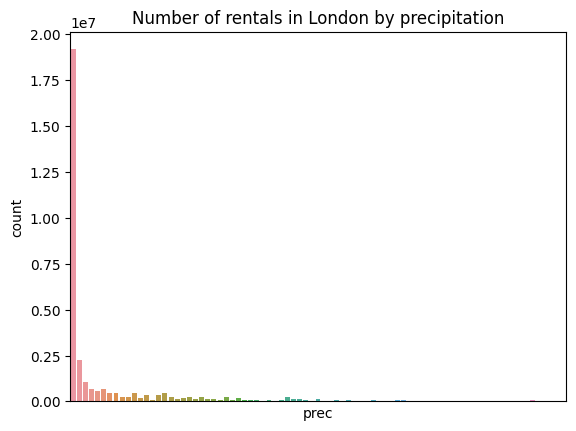

In [13]:
df_plot = ( bikes_and_stations
                .groupby('prec')
                .count()
                .sort('prec', ascending=True)
                .toPandas()
          )
plotBar(df_plot, 'prec', 'count')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.title('Number of rentals in London by precipitation')
plt.show()

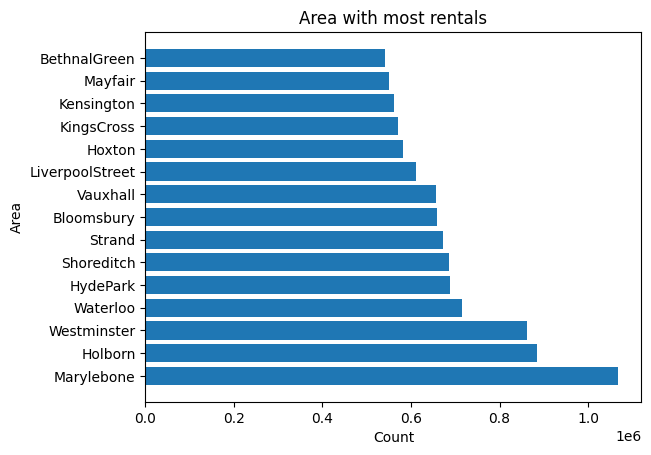

In [14]:
import matplotlib.pyplot as plt

# Assuming you have a PySpark DataFrame called 'bikes_and_stations' and a column named 'start_area'
df_plot = bikes_and_stations.groupBy('area_cleaned').count().orderBy('count', ascending=False).limit(15).toPandas()

# Creating the horizontal bar plot
plt.barh(df_plot['area_cleaned'], df_plot['count'])

# Adding labels and title
plt.xlabel('Count')
plt.ylabel('Area')
plt.title('Area with most rentals')

# Displaying the plot
plt.show()


### Map Visualizing:

In [15]:
from pyspark.sql.functions import sum,avg,max,count

group_cols = ["start_station_id"]

grouped = bikes_and_stations.groupBy(group_cols) \
                .agg(sum("num_rentals").alias("sum_rentals")
                     )

filename = 'ABD_TG/csv/london_stations.csv'
stations = spark.read.csv(filename, header="true", inferSchema="true", sep=',')

grouped = grouped.join(stations, grouped.start_station_id == stations.station_id, 'left')

grouped.show(1, truncate=False, vertical=True)

-RECORD 0----------------------------------
 start_station_id | 46                     
 sum_rentals      | 94457                  
 station_id       | 46                     
 station_name     | Nesham Street, Wapping 
 longitude        | -0.06691               
 latitude         | 51.5071                
only showing top 1 row



In [16]:
#!pip install folium
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

df = grouped.toPandas()

# find the row of the house which has the highest price
maxpr=df.loc[df['sum_rentals'].idxmax()]

# define a function to draw a basemap easily
def generateBaseMap(default_location=[51.5292, -0.109971], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

df_copy = df.copy()
df_copy['count'] = 1
basemap = generateBaseMap()
# add carton position map
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)
# add a marker for the house which has the highest price
folium.Marker([maxpr['latitude'], maxpr['longitude']],popup='Highest Rentals: $'+str(format(maxpr['sum_rentals'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)
# add heatmap
HeatMap(data=df_copy[['latitude','longitude','count']].groupby(['latitude','longitude']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap

## Visualizing prediction results:

In [17]:
grouped = spark.read.parquet("dataout-aws/predicted")

In [23]:
import pyspark.sql.functions as F
from pyspark.sql.functions import sum,avg,max,count

grouped_plot = grouped.groupBy('date') \
                .agg(sum('real_rentals'),
                     sum('pred_rentals')
                    )

grouped_plot = grouped_plot.sort('date')

grouped_plot = grouped_plot.withColumn(
    "date", 
    F.to_date(F.col("date").cast("string"), "yyyyMMdd")
)
grouped_plot.show(5)

+----------+-----------------+-----------------+
|      date|sum(real_rentals)|sum(pred_rentals)|
+----------+-----------------+-----------------+
|2019-06-01|             8076|8078.193735231619|
|2019-06-02|             6637|6641.415805886153|
|2019-06-03|             7446|7447.076576135585|
|2019-06-04|             6313|6313.230112359551|
|2019-06-05|             7314|           7314.0|
+----------+-----------------+-----------------+
only showing top 5 rows



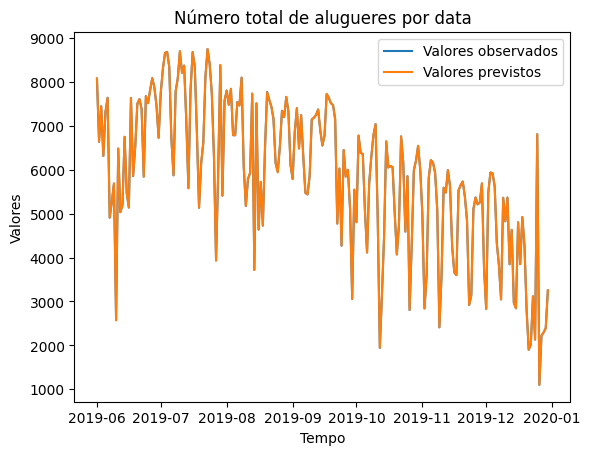

In [24]:
import matplotlib.pyplot as plt

# Sample data

df_plot = grouped_plot.toPandas()



# Create the plot
plt.plot(df_plot['date'], df_plot['sum(real_rentals)'], label='Valores observados')
plt.plot(df_plot['date'], df_plot['sum(pred_rentals)'], label='Valores previstos')

# Set labels and title
plt.xlabel('Tempo')
plt.ylabel('Valores')
plt.title('Número total de alugueres por data')

# Add legend
plt.legend()

# Display the plot
plt.show()

In [26]:
import pyspark.sql.functions as F

grouped_plot = grouped.groupBy('area_cleaned') \
                .agg(sum('real_rentals'),
                     sum('pred_rentals')
                    )

grouped_plot = grouped_plot.orderBy(F.col('sum(real_rentals)').desc())

grouped_plot.show(5)

+------------+-----------------+------------------+
|area_cleaned|sum(real_rentals)| sum(pred_rentals)|
+------------+-----------------+------------------+
|    HydePark|            41007|41018.073372499275|
|  Marylebone|            39165|39165.401360859076|
|     Holborn|            33339|33340.160680429544|
| Westminster|            32389|32385.938174258237|
|    Waterloo|            31915|31913.784274735135|
+------------+-----------------+------------------+
only showing top 5 rows



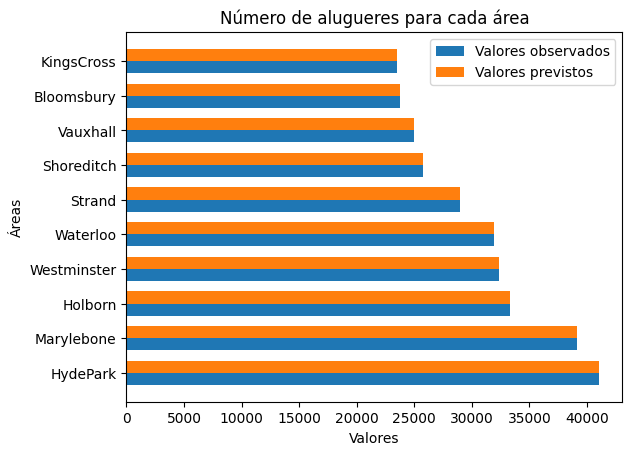

23/05/28 11:04:40 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 794191 ms exceeds timeout 120000 ms
23/05/28 11:04:40 WARN SparkContext: Killing executors is not supported by current scheduler.


In [28]:
import matplotlib.pyplot as plt
import numpy as np
# Sample data

df_plot = grouped_plot.limit(10).toPandas()

# Set the width of each bar
bar_width = 0.35

# Create the plot
fig, ax = plt.subplots()
index = np.arange(len(df_plot['area_cleaned']))

# Plot the real values
rects1 = ax.barh(index, df_plot['sum(real_rentals)'], bar_width, label='Valores observados')

# Plot the predicted values with adjusted position
rects2 = ax.barh(index + bar_width, df_plot['sum(pred_rentals)'], bar_width, label='Valores previstos')

# Set y-axis labels
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(df_plot['area_cleaned'])

# Add labels and title
ax.set_xlabel('Valores')
ax.set_ylabel('Áreas')
ax.set_title('Número de alugueres para cada área')

# Add legend
ax.legend()

# Display the plot
plt.show()

## Valores previstos

In [30]:
stream = spark.read.parquet("dataout-aws/stream")
stream.show(5, vertical=True)

-RECORD 0------------------------------
 Hour           | 22                   
 Day            | 25                   
 DayofWeek      | 5                    
 Month          | 6                    
 end_station_id | 214.0                
 num_rentals    | 1                    
 station_id     | 341                  
 station_name   | Craven Street, St... 
 longitude      | -0.126021            
 latitude       | 51.5081              
 area_cleaned   | Strand               
 date           | 20200625             
 sunshine       | 15.7                 
 mean           | 25.9                 
 cloud          | 1.0                  
 prec           | 0.0                  
 press          | 101560.0             
-RECORD 1------------------------------
 Hour           | 22                   
 Day            | 25                   
 DayofWeek      | 5                    
 Month          | 6                    
 end_station_id | 294.0                
 num_rentals    | 1                    


In [32]:
from pyspark.ml import PipelineModel

GBT_model = PipelineModel.load('dataout-aws/model-GBT')

In [34]:
pred_stream = GBT_model.transform(stream)
pred_stream.show(5, vertical=True)

23/05/28 11:17:42 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/05/28 11:17:43 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/28 11:17:43 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
-RECORD 0----------------------------------
 Hour               | 22                   
 Day                | 25                   
 DayofWeek          | 5                    
 Month              | 6                    
 end_station_id     | 214.0                
 num_rentals        | 1                    
 station_id         | 341                  
 station_name       | Craven Street, St... 
 longitude          | -0.126021            
 latitude           | 51.5081              
 area_cleaned       | Strand               
 date               | 20200625             
 s

### Áreas com mais afluência durante o mês de janeiro

In [35]:
jan_filter = pred_stream.filter(F.col('Month') == 1)
jan_filter.count()

125565

In [68]:
grouped_plot = jan_filter.groupBy('area_cleaned') \
                .agg(
                     sum('prediction').alias('Estimated Value')
                    )

grouped_plot = grouped_plot.orderBy(F.col('Estimated Value').desc())

grouped_plot.show(5)

+------------+------------------+
|area_cleaned|   Estimated Value|
+------------+------------------+
|     Holborn| 4346.230112359551|
|  Marylebone|            4284.0|
|    Waterloo|4040.4103370786515|
| Westminster|            3811.0|
|  Bloomsbury|            2990.0|
+------------+------------------+
only showing top 5 rows



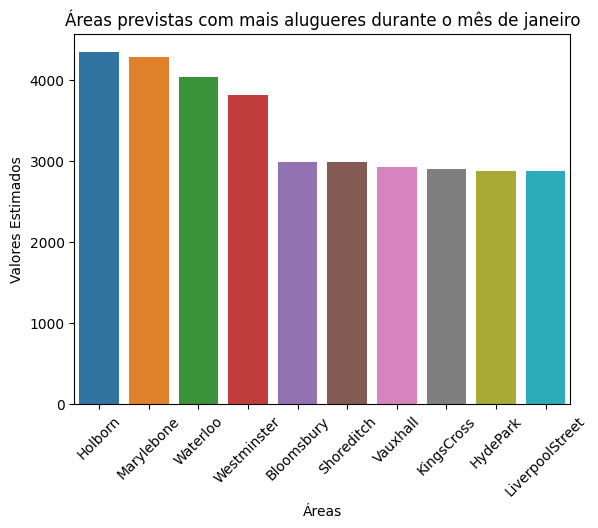

In [70]:
import matplotlib.pyplot as plt
import numpy as np
# Sample data

df_plot = grouped_plot.limit(10).toPandas()
plotBar(df_plot, 'area_cleaned', 'Estimated Value')

plt.xticks(rotation=45)
plt.ylabel('Valores Estimados')
plt.xlabel('Áreas')
plt.title('Áreas previstas com mais alugueres durante o mês de janeiro')
plt.show()

#### Afluência no próximo dia útil (2/1/2020)

In [42]:
first_filter = pred_stream.filter(F.col('date') == 20200102)
first_filter.count()

3109

##### Por hora

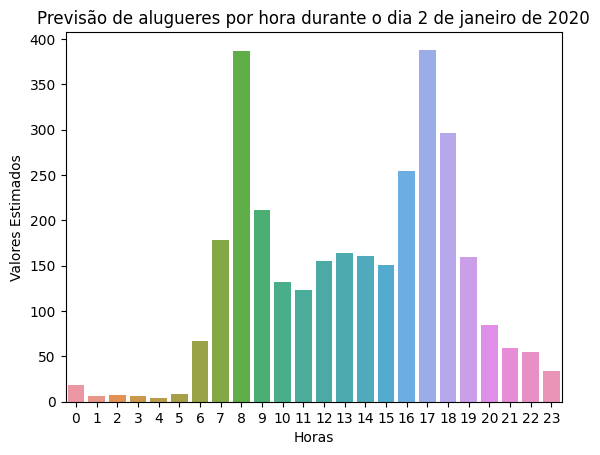

In [71]:
df_plot = ( first_filter
                .groupby('Hour')
                .count()
                .sort('Hour', ascending=True)
                .toPandas()
          )
plotBar(df_plot, 'Hour', 'count')
plt.ylabel('Valores Estimados')
plt.xlabel('Horas')
plt.title('Previsão de alugueres por hora durante o dia 2 de janeiro de 2020')
plt.show()

##### As 10 areas com mais afluência

In [50]:
grouped_plot = first_filter.groupBy('area_cleaned') \
                .agg(
                     sum('prediction').alias('Estimated Value')
                    )

grouped_plot = grouped_plot.orderBy(F.col('Estimated Value').desc())

grouped_plot.show(5)

+------------+---------------+
|area_cleaned|Estimated Value|
+------------+---------------+
|  Marylebone|          145.0|
|     Holborn|          118.0|
|    HydePark|          109.0|
|    Waterloo|           99.0|
|  Shoreditch|           85.0|
+------------+---------------+
only showing top 5 rows



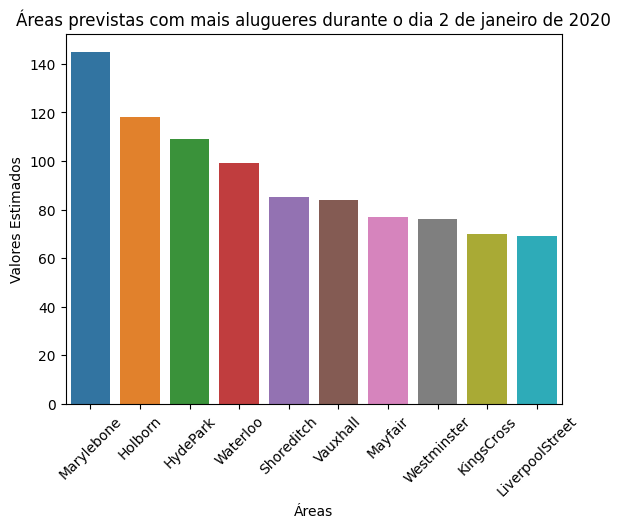

In [61]:
df_plot = grouped_plot.limit(10).toPandas()
plotBar(df_plot, 'area_cleaned', 'Estimated Value')

plt.xticks(rotation=45)
plt.ylabel('Valores Estimados')
plt.xlabel('Áreas')
plt.title('Áreas previstas com mais alugueres durante o dia 2 de janeiro de 2020')
plt.show()

##### Estimativa do crescimento dos alugueres ao longo do tempo

In [63]:
import pyspark.sql.functions as F
from pyspark.sql.functions import sum,avg,max,count

grouped_plot = pred_stream.groupBy('date') \
                .agg(sum('prediction').alias('Estimated Value')
                    )

grouped_plot = grouped_plot.sort('date')

grouped_plot = grouped_plot.withColumn(
    "date", 
    F.to_date(F.col("date").cast("string"), "yyyyMMdd")
)
grouped_plot.show(5)

+----------+------------------+
|      date|   Estimated Value|
+----------+------------------+
|2020-01-01| 2195.780455710439|
|2020-01-02|            3594.0|
|2020-01-03| 3697.050337078652|
|2020-01-04|            3096.0|
|2020-01-05|2544.2462243985965|
+----------+------------------+
only showing top 5 rows



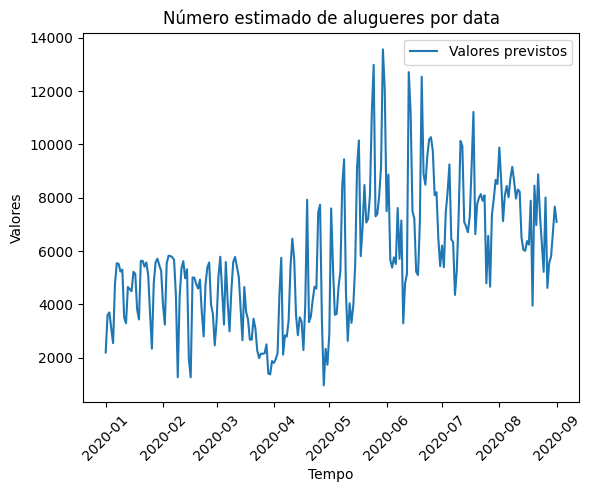

In [66]:
import matplotlib.pyplot as plt

# Sample data

df_plot = grouped_plot.toPandas()

# Create the plot
plt.plot(df_plot['date'], df_plot['Estimated Value'], label='Valores previstos')

# Set labels and title
plt.xticks(rotation=45)
plt.xlabel('Tempo')
plt.ylabel('Valores')
plt.title('Número estimado de alugueres por data')

# Add legend
plt.legend()

# Display the plot
plt.show()